In [3]:
import pandas as pd
import numpy as np
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

%pylab inline
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use('seaborn-poster')
sns.set_palette('Set1', 10, desat=0.75)

from sklearn.metrics import log_loss
DATA_PATH = 'data/'

Populating the interactive namespace from numpy and matplotlib


# Prepearing datasets

In [7]:
train_qids = pd.read_csv(os.path.join(DATA_PATH, 'train_ids.csv'))
test_qids  = pd.read_csv(os.path.join(DATA_PATH, 'test_ids.csv'))

In [8]:
def seen_in_train(row):
    """
    returns:
        0 if no question in pair was seen in train dataset
        1 if single question in pair was seen in train dataset
        2 if both questions in pair were seen in train dataset
    """
    seen = 0
    if row.qid1 in train_qids_dict:
        seen+=1
    if row.qid2 in train_qids_dict:
        seen+=1
    return seen

train_qids_dict = dict((qid, None) for qid in pd.concat([train_qids.qid1, train_qids.qid2]).unique())

test_qids['seen'] = test_qids.apply(lambda row: seen_in_train(row), axis=1)
test_qids.seen.value_counts()

0    2160290
1     151119
2      34387
Name: seen, dtype: int64

In [9]:
%%time

train_qids['qid_max'] = train_qids.apply(lambda row: max(row['qid1'], row['qid2']), axis=1)
train_qids['qid_min'] = train_qids.apply(lambda row: min(row['qid1'], row['qid2']), axis=1)
train_qids['qid_sum'] = train_qids.apply(lambda row: row['qid1']+row['qid2'], axis=1)

test_qids['qid_max']  = test_qids .apply(lambda row: max(row['qid1'], row['qid2']), axis=1)
test_qids['qid_min']  = test_qids .apply(lambda row: min(row['qid1'], row['qid2']), axis=1)
test_qids['qid_sum']  = test_qids .apply(lambda row: row['qid1']+row['qid2'], axis=1)

train_qids.to_csv(os.path.join(DATA_PATH, 'train_ids.csv'),index=False)
test_qids .to_csv(os.path.join(DATA_PATH, 'test_ids.csv'), index=False)

CPU times: user 3min 59s, sys: 3.12 s, total: 4min 2s
Wall time: 4min 4s


## Probing LB to find the best mean coefficient for each seen group (just 10 submissions)

In [14]:
data = pd.concat((pd.read_csv(os.path.join('subs', 'tfidf_LB12605.csv'), usecols=[0]),
                  pd.read_csv(os.path.join(DATA_PATH, 'test_ids.csv'), usecols=[2])), axis=1, copy=False)
data.columns = ['pred', 'seen']
data.head()

,pred,seen
0,0.000187,0
1,0.265166,0
2,0.298197,0
3,0.000128,0
4,0.269756,0


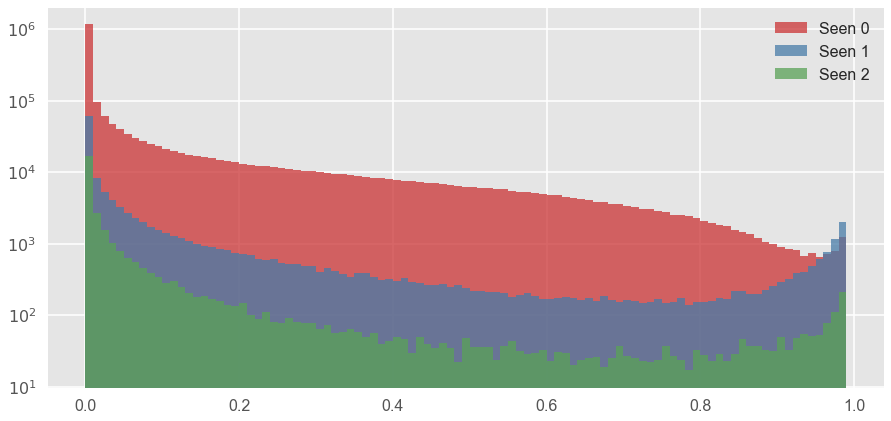

In [15]:
plt.figure(figsize=(15,7))

plt.hist(data[data.seen==0].pred, label='Seen 0', alpha=0.75, bins=np.arange(0, 1, 0.01))
plt.hist(data[data.seen==1].pred, label='Seen 1', alpha=0.75, bins=np.arange(0, 1, 0.01))
plt.hist(data[data.seen==2].pred, label='Seen 2', alpha=0.75, bins=np.arange(0, 1, 0.01))

plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
%%time
def make_submission(data, seen0, seen1, seen2):
    """
    This function calibrates probabilities for each of three groups separately.
    input:
        data - pandas DataFrame, must contain columns 'pred' and 'seen'. Pred is the probability to be scaled and
            seen - number of the group this object belongs to.
        seen0/1/2 - suggested duperates for each group in test dataset. 
    """
    def mod_stat(row, train_duperate=0.3692, 
                 seen0=0.174, 
                 seen1=0.174,
                 seen2=0.174):
        """
        scaling the probabilities using train duperate and test group-qise duperate. 
        More info: https://www.kaggle.com/c/quora-question-pairs/discussion/31179
        """
        y = row.pred
        seen = row.seen
        if seen==0:
            test_duperate = seen0
        elif seen==1:
            test_duperate = seen1
        elif seen==2:
            test_duperate = seen2

        a = test_duperate/train_duperate
        b = (1-test_duperate) / (1-train_duperate)
        return a*y / (a*y + b*(1-y))

    output = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'), usecols=['test_id'])
    output['is_duplicate'] = data.apply(lambda row: mod_stat(row, seen0=seen0, seen1=seen1, seen2=seen2), axis=1)
    output.to_csv('final_s0_'+str(seen0)[2:]+'_s1_'+str(seen1)[2:]+'_s2_'+str(seen2)[2:]+'.csv', index=False)
    
make_submission(data, seen0=0.174, seen1=0.174, seen2=0.075)

After just 10 submissions we are able to predict test duperates for each group. Let's plot them

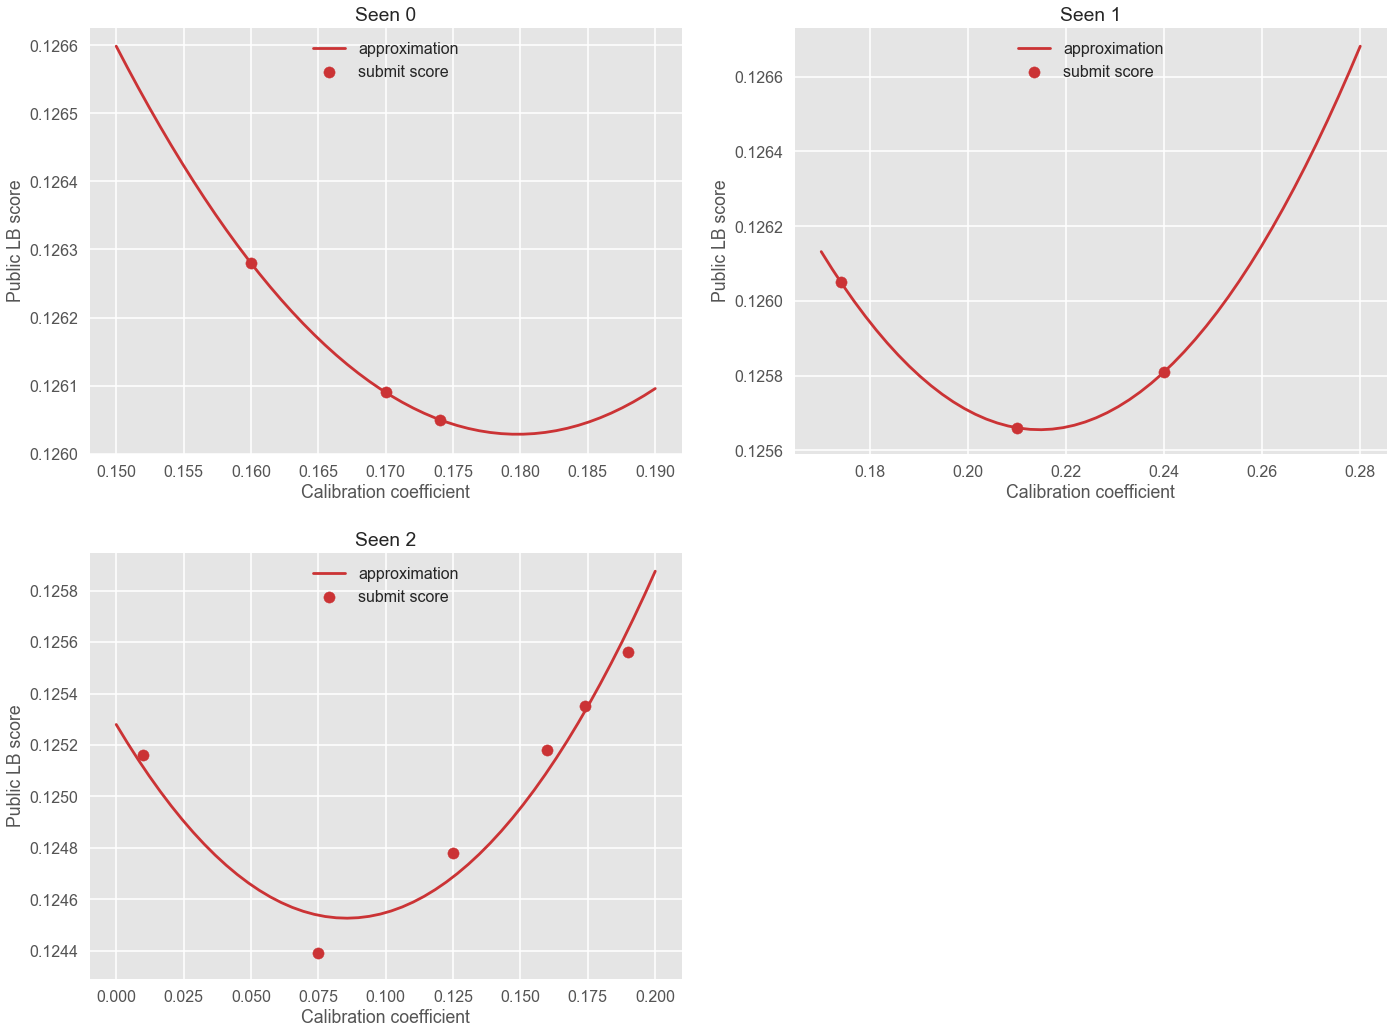

In [17]:
plt.figure(figsize=(20,15))

# Seen 0. x and y are calibration coefficients for seen0 and public LB scores respectively
x = [.174, .160, .170]
y = [.12605, .12628, .12609]

plt.subplot(2,2,1)
p = np.poly1d(np.polyfit(x,y, deg=2))
xp = np.linspace(.15, .19)
plt.title('Seen 0')
plt.plot(xp, p(xp), label='approximation')
plt.scatter(x, y, label='submit score')
plt.legend(loc='upper center')
plt.xlabel('Calibration coefficient')
plt.ylabel('Public LB score')


# Seen 1. x and y are calibration coefficients for seen0 and public LB scores respectively
x = [.174,   .210,   .240]
y = [.12605, .12566, .12581]

plt.subplot(2,2,2)
p = np.poly1d(np.polyfit(x,y, deg=2))
xp = np.linspace(.17, .28)
plt.title('Seen 1')
plt.plot(xp, p(xp), label='approximation')
plt.scatter(x, y, label='submit score')
plt.legend(loc='upper center')
plt.xlabel('Calibration coefficient')
plt.ylabel('Public LB score')


# Seen 2. x and y are calibration coefficients for seen0 and public LB scores respectively
x = [.174, .190, .160, .125, .075, 0.01]
y = [.12535, .12556, .12518, .12478, .12439, .12516]

plt.subplot(2,2,3)
p = np.poly1d(np.polyfit(x,y, deg=2))
xp = np.linspace(0, .2)
plt.title('Seen 2')
plt.plot(xp, p(xp), label='approximation')
plt.scatter(x, y, label='submit score')
plt.legend(loc='upper center')
plt.xlabel('Calibration coefficient')
plt.ylabel('Public LB score')

plt.tight_layout(pad=3)
plt.show()

## Qid based calibration

In [18]:
import pandas as pd
import numpy as np
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

%pylab inline
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.metrics import log_loss

train = pd.concat((pd.read_csv(os.path.join(DATA_PATH,'train_ids.csv')),
                   pd.read_csv(os.path.join(DATA_PATH,'target.csv'))
                  ), axis=1)
test  = pd.read_csv(os.path.join(DATA_PATH,'test_ids.csv'))
test.head()

Populating the interactive namespace from numpy and matplotlib


,qid1,qid2,seen,qid_max,qid_min,qid_sum
0,537363,537364,0,537364,537363,1074727
1,537365,537366,0,537366,537365,1074731
2,537367,537368,0,537368,537367,1074735
3,537369,537370,0,537370,537369,1074739
4,537371,537372,0,537372,537371,1074743


In [26]:
# Read uncalibrated prediction and add ids and seen groups. 

data = pd.concat((pd.read_csv(os.path.join('subs', 'tfidf_LB12605.csv'), usecols=[0]),
                  pd.read_csv(os.path.join(DATA_PATH, 'test_ids.csv'))), axis=1)
data.columns = ['pred']+list(data.columns)[1:]
data.head()

,pred,qid1,qid2,seen,qid_max,qid_min,qid_sum
0,0.000187,537363,537364,0,537364,537363,1074727
1,0.265166,537365,537366,0,537366,537365,1074731
2,0.298197,537367,537368,0,537368,537367,1074735
3,0.000128,537369,537370,0,537370,537369,1074739
4,0.269756,537371,537372,0,537372,537371,1074743


# Seen 0 calibration

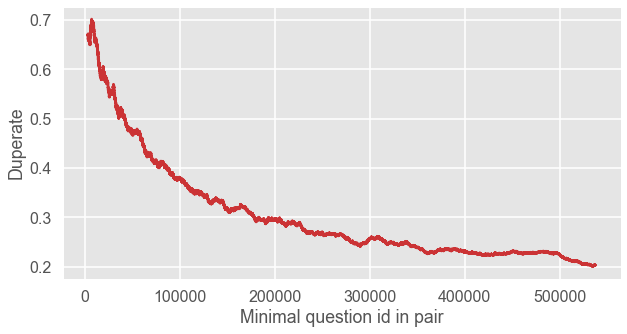

In [30]:
# Sort the train dataset by id (acending) and check the avg target with rolling window
id_value = 'qid_min'
train_sorted = train.sort_values(by=[id_value], ascending=True)
train_sorted['dupe_rate'] = train_sorted.target.rolling(window=10000, min_periods=10000).mean()
plt.figure(figsize=(10,5))
plt.plot(train_sorted[id_value], train_sorted['dupe_rate'])
plt.ylabel('Duperate')
plt.xlabel('Minimal question id in pair')
plt.show()

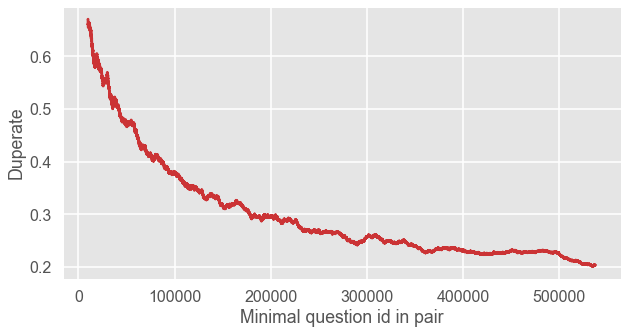

In [31]:
# The upper part of the graph is strange. Let's crop it by first 10K values and plot corrected graph
train_sorted = train.sort_values(by=[id_value], ascending=True)
train_sorted['dupe_rate'] = train_sorted.target.rolling(window=10000, min_periods=10000).mean()
train_sorted = train_sorted[train_sorted[id_value]>10000]

plt.figure(figsize=(10,5))
plt.plot(train_sorted[id_value], train_sorted['dupe_rate'])
plt.ylabel('Duperate')
plt.xlabel('Minimal question id in pair')
plt.show()

Let's try to predict duperate in train dataset using only qid_min.

We'll use two features: unprocessed *qid_min* and a tricky one *qid_min_rev* which is supposed to catch a 1/x kind of dependancy. 60K in denominator - regularization parameter, which was adjusted by visual validation and by MSE.

Train MSE: 0.21206


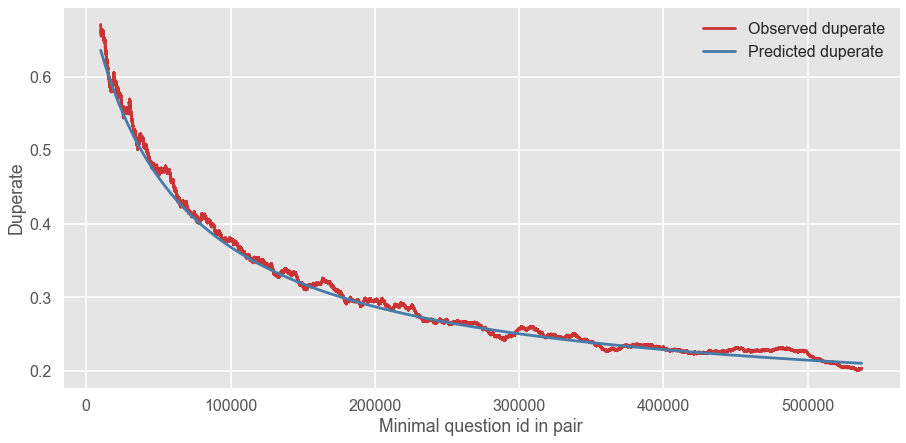

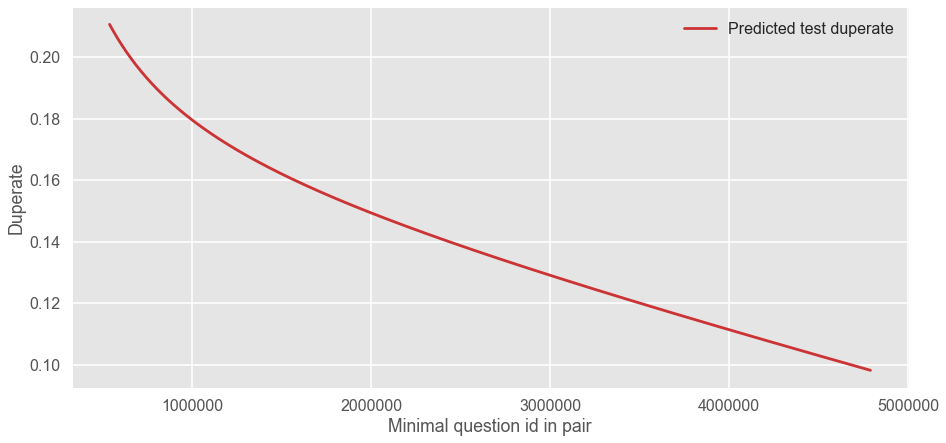

Test seen0 mean predicted duperate: 0.1421
Test seen0 real duperate: 0.18


In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

regul = 60000 
seen = 0

train_sorted['qid_min_rev'] = train_sorted[id_value].apply(lambda x: 1/(x+regul))
features = ['qid_min_rev', id_value]

lr = LinearRegression()
lr.fit(train_sorted[features], train_sorted['target'])
train_sorted['pred'] = lr.predict(train_sorted[features])

print ('Train MSE:', round(mean_squared_error(train_sorted['pred'], train_sorted['target']), 5))

plt.figure(figsize=(15,7))
plt.plot(train_sorted[id_value], train_sorted['dupe_rate'], label='Observed duperate')
plt.plot(train_sorted[id_value], train_sorted['pred'], label='Predicted duperate')
plt.legend()
plt.ylabel('Duperate')
plt.xlabel('Minimal question id in pair')
plt.show()


test_sorted = test.sort_values(by=[id_value], ascending=True)
test_sorted = test_sorted[test_sorted.seen==seen] 
test_sorted['qid_min_rev'] = test_sorted[id_value].apply(lambda x: 1/(x+regul))
test_sorted['pred'] = lr.predict(test_sorted[features])

plt.figure(figsize=(15,7))
plt.plot(test_sorted [id_value], test_sorted ['pred'], label='Predicted test duperate')
plt.legend()
plt.ylabel('Duperate')
plt.xlabel('Minimal question id in pair')
plt.show()

print ('Test seen0 mean predicted duperate:', round(test_sorted.pred.mean(),4))
print ('Test seen0 real duperate:', 0.18)

Real duperate is way higher than predicted one. The reason for it is that there is a number of fake questions in test dataset, that are not counting towards LB score, but have ids. Therefore number of real question ids is lower. We have to take only first **N** duperate prediction. Assuming fake questions are distributed uniformly throughout the test dataset, we'll select the first part of the graph with mean duperate equals to observed by LB probing.


In [46]:
true_count = 1000
while test_sorted.pred.iloc[:true_count].mean() > 0.18: 
    true_count+=1000
print ('Total number of quesiton pairs in test dataset is seen0 group:', test_sorted.shape[0])
print ('Number of real quesiton pairs in test dataset is seen0 group:', true_count)
print ('Mean duperate for real questions:', round(test_sorted.pred.iloc[:true_count].mean(),3))

Total number of quesiton pairs in test dataset is seen0 group: 2160290
Number of real quesiton pairs in test dataset is seen0 group: 629000
Mean duperate for real questions: 0.18


Thus our duperate curve should be projected from the range of *[min_id : true_count]* to th range of *[min_id : max_id]* with the average duperate preserved. Resulting graph is plotted below.

Corrected mean: 0.1794712859740714


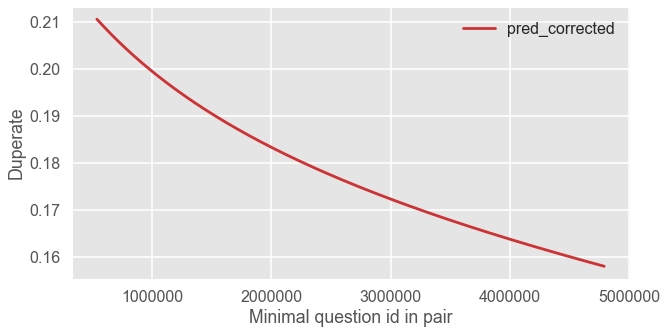

In [48]:
all_count = test.shape[0]

min_id = test_sorted[id_value].min()
max_id = test_sorted[id_value].max()

scale_value = (test_sorted.iloc[true_count][id_value] - min_id)/(max_id - min_id)

test_sorted['true_id'] = test_sorted[id_value].apply(lambda x: (x - min_id)*scale_value + min_id)
test_sorted['true_qid_min_rev'] = test_sorted.true_id.apply(lambda true_id: 1/(true_id+regul))
test_sorted['pred_corrected'] = lr.predict(test_sorted[['true_qid_min_rev', 'true_id']])

print ('Corrected mean:', test_sorted['pred_corrected'].mean())

plt.figure(figsize=(10,5))
plt.plot(test_sorted[id_value], test_sorted.pred_corrected)
plt.legend()
plt.ylabel('Duperate')
plt.xlabel('Minimal question id in pair')
plt.show()

Adding dueprates for seen0 group into submission

In [62]:
data['true_id'] = data[id_value].apply(lambda x: (x - min_id)*scale_value + min_id)
data['true_qid_min_rev'] = data.true_id.apply(lambda true_id: 1/(true_id+regul))
data['DR_seen0'] = lr.predict(data[['true_qid_min_rev', 'true_id']])

Do the same thing for the groups seen1 and seen2

# Seen 1 calibration

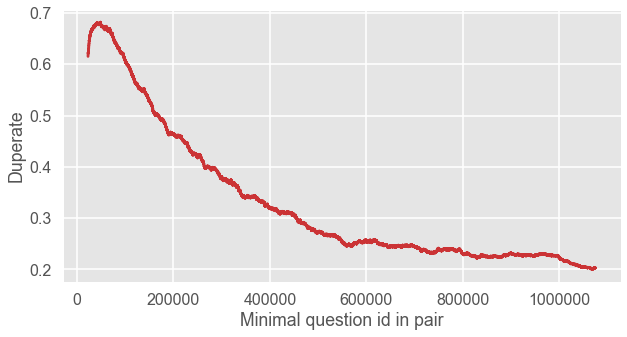

In [63]:
# Sort the train dataset by id (acending) and check the avg target with rolling window
id_value = 'qid_sum'
train_sorted = train.sort_values(by=[id_value], ascending=True)
train_sorted['dupe_rate'] = train_sorted.target.rolling(window=10000, min_periods=10000).mean()

plt.figure(figsize=(10,5))
plt.plot(train_sorted[id_value], train_sorted['dupe_rate'])
plt.ylabel('Duperate')
plt.xlabel('Minimal question id in pair')
plt.show()

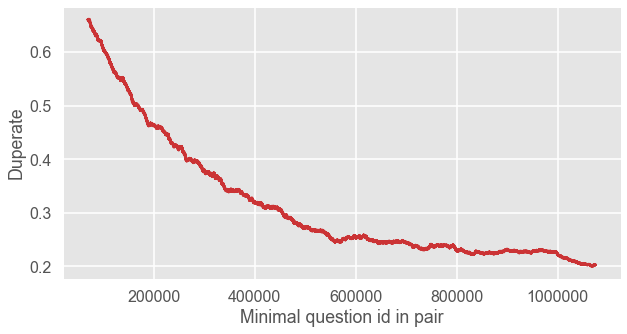

In [64]:
# The upper part of the graph is strange. Let's crop it by first 10K values and plot corrected graph
train_sorted = train.sort_values(by=[id_value], ascending=True)
train_sorted['dupe_rate'] = train_sorted.target.rolling(window=10000, min_periods=10000).mean()
train_sorted = train_sorted[train_sorted[id_value]>70000]

plt.figure(figsize=(10,5))
plt.plot(train_sorted[id_value], train_sorted['dupe_rate'])
plt.ylabel('Duperate')
plt.xlabel('Minimal question id in pair')
plt.show()

Let's try to predict duperate in train dataset using only qid_min.

We'll use two features: unprocessed *qid_min* and a tricky one *qid_min_rev* which is supposed to catch a 1/x kind of dependancy. 110K in denominator - regularization parameter, which was adjusted by visual validation and by MSE.

Train MSE: 0.20959


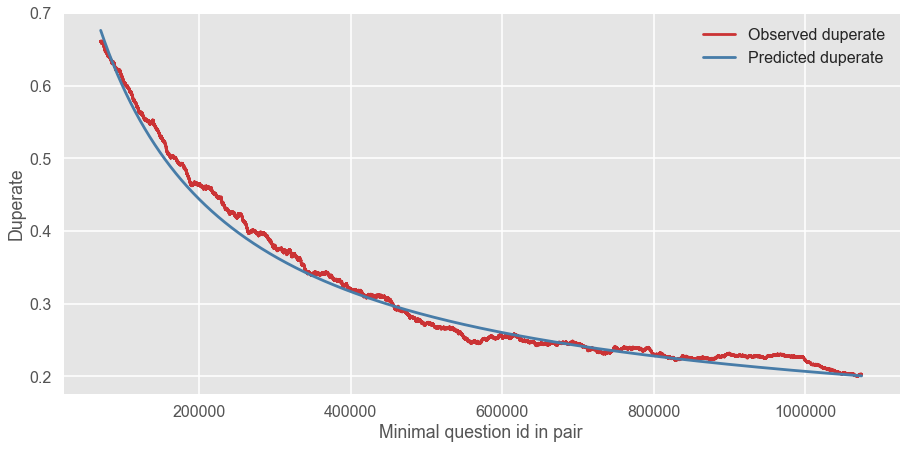

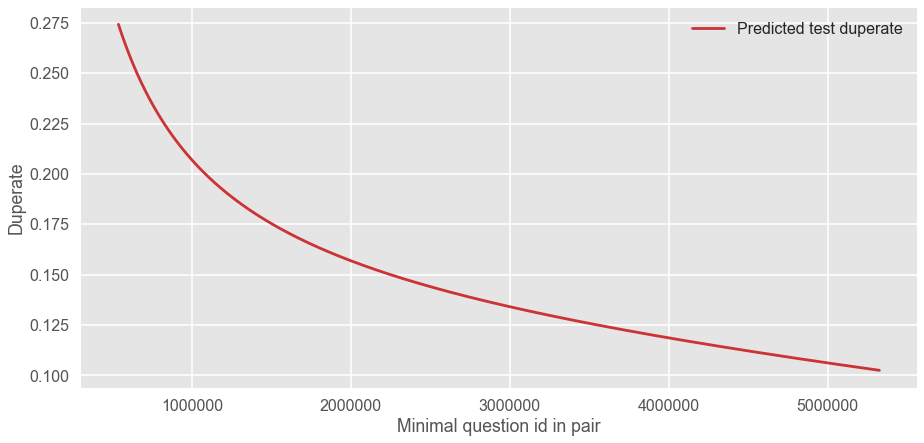

Test seen1 mean predicted duperate: 0.1638
Test seen1 real duperate: 0.21


In [65]:
regul = 110000 
seen = 1

train_sorted['qid_min_rev'] = train_sorted[id_value].apply(lambda x: 1/(x+regul))
features = ['qid_min_rev', id_value]

lr = LinearRegression()
lr.fit(train_sorted[features], train_sorted['target'])
train_sorted['pred'] = lr.predict(train_sorted[features])

print ('Train MSE:', round(mean_squared_error(train_sorted['pred'], train_sorted['target']), 5))

plt.figure(figsize=(15,7))
plt.plot(train_sorted[id_value], train_sorted['dupe_rate'], label='Observed duperate')
plt.plot(train_sorted[id_value], train_sorted['pred'], label='Predicted duperate')
plt.legend()
plt.ylabel('Duperate')
plt.xlabel('Minimal question id in pair')
plt.show()

test_sorted = test.sort_values(by=[id_value], ascending=True)
test_sorted = test_sorted[test_sorted.seen==seen] 
test_sorted['qid_min_rev'] = test_sorted[id_value].apply(lambda x: 1/(x+regul))
test_sorted['pred'] = lr.predict(test_sorted[features])

plt.figure(figsize=(15,7))
plt.plot(test_sorted [id_value], test_sorted ['pred'], label='Predicted test duperate')
plt.legend()
plt.ylabel('Duperate')
plt.xlabel('Minimal question id in pair')
plt.show()

print ('Test seen1 mean predicted duperate:', round(test_sorted.pred.mean(),4))
print ('Test seen1 real duperate:', 0.21)

In [66]:
true_count = 1000
while test_sorted.pred.iloc[:true_count].mean() > 0.21: 
    true_count+=1000
    
print ('test predicted dupe rate avg:', test_sorted.pred.mean())
print (true_count, test_sorted.pred.iloc[:true_count].mean())

test predicted dupe rate avg: 0.16378895782423666
58000 0.20994793855359944


Corrected mean: 0.21955928671410507


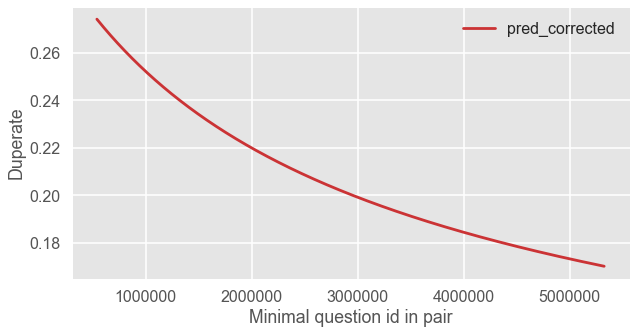

In [67]:
all_count = test.shape[0]

min_id = test_sorted[id_value].min()
max_id = test_sorted[id_value].max()

scale_value = (test_sorted.iloc[true_count][id_value] - min_id)/(max_id - min_id)

test_sorted['true_id'] = test_sorted[id_value].apply(lambda x: (x - min_id)*scale_value + min_id)
test_sorted['true_qid_min_rev'] = test_sorted.true_id.apply(lambda true_id: 1/(true_id+regul))
test_sorted['pred_corrected'] = lr.predict(test_sorted[['true_qid_min_rev', 'true_id']])

print ('Corrected mean:', test_sorted['pred_corrected'].mean())

plt.figure(figsize=(10,5))
plt.plot(test_sorted[id_value], test_sorted.pred_corrected)
plt.legend()
plt.ylabel('Duperate')
plt.xlabel('Minimal question id in pair')
plt.show()

In [68]:
data['true_id'] = data[id_value].apply(lambda x: (x - min_id)*scale_value + min_id)
data['true_qid_min_rev'] = data.true_id.apply(lambda true_id: 1/(true_id+regul))
data['DR_seen1'] = lr.predict(data[['true_qid_min_rev', 'true_id']])

## Seen2

In [69]:
# This group is too small and duperate is far from the one in train daatset, so we'll use constant scaling/
data['DR_seen2'] = 0.075

## Final sabmit

In [72]:
%%time
def mod_stat(row, train_duperate=0.3692):

    y = row.pred
    seen = row.seen
    if seen==0:
        test_duperate = row.DR_seen0
    elif seen==1:
        test_duperate = row.DR_seen1
    elif seen==2:
        test_duperate = row.DR_seen2
        
    a = test_duperate/train_duperate
    b = (1-test_duperate) / (1-train_duperate)
    return a*y / (a*y + b*(1-y))

output = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'), usecols=['test_id'])
output['is_duplicate'] = data.apply(lambda row: mod_stat(row), axis=1)
output.to_csv('Final_submit.csv', index=False)

CPU times: user 2min 2s, sys: 1.81 s, total: 2min 4s
Wall time: 2min 5s


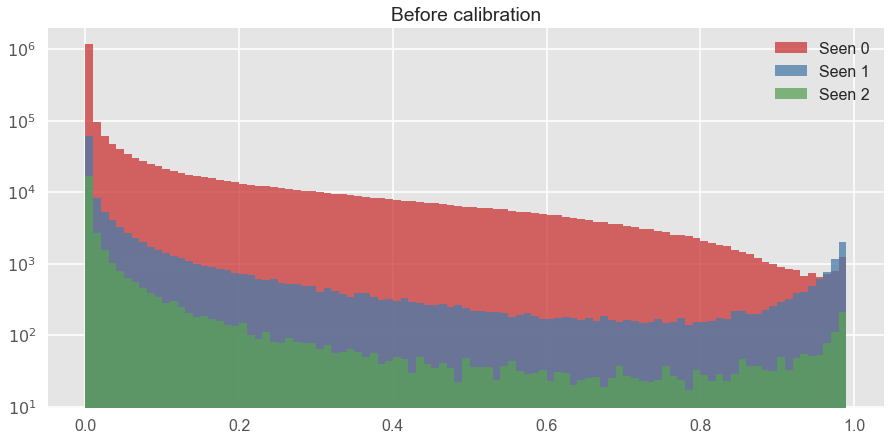

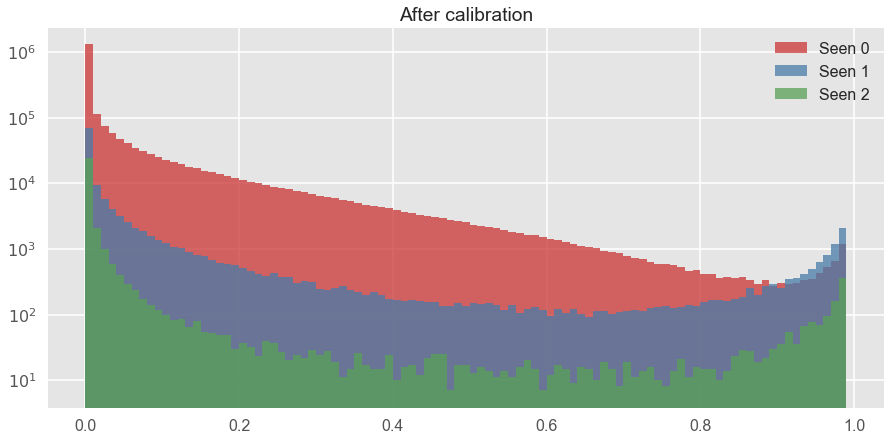

In [84]:
data['prob_diff'] = output.is_duplicate-data.pred
data['calibrated'] = output.is_duplicate

plt.figure(figsize=(15,7))

plt.title('Before calibration')
plt.hist(data[data.seen==0].pred, label='Seen 0', alpha=0.75, bins=np.arange(0, 1, 0.01))
plt.hist(data[data.seen==1].pred, label='Seen 1', alpha=0.75, bins=np.arange(0, 1, 0.01))
plt.hist(data[data.seen==2].pred, label='Seen 2', alpha=0.75, bins=np.arange(0, 1, 0.01))

plt.legend()
plt.yscale('log')
plt.show()

plt.figure(figsize=(15,7))

plt.title('After calibration')
plt.hist(data[data.seen==0].calibrated, label='Seen 0', alpha=0.75, bins=np.arange(0, 1, 0.01))
plt.hist(data[data.seen==1].calibrated, label='Seen 1', alpha=0.75, bins=np.arange(0, 1, 0.01))
plt.hist(data[data.seen==2].calibrated, label='Seen 2', alpha=0.75, bins=np.arange(0, 1, 0.01))

plt.legend()
plt.yscale('log')
plt.show()